<a href="https://colab.research.google.com/github/hongjinkong/opensw/blob/main/result/deepfakedetection_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mystlee/dfdc_deepfake_challenge.git

Cloning into 'dfdc_deepfake_challenge'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 134 (delta 23), reused 4 (delta 4), pack-reused 65 (from 1)
Receiving objects: 100% (134/134), 69.20 MiB | 14.46 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (63/63), done.


In [13]:
!pip install -U tensorflow
!pip install -U keras
!pip install efficientnet


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
pip install --upgrade tensorflow

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0566 - val_loss: 0.0225
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0169 - val_loss: 0.0095
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_162']. Received: the structure of inputs=*
  warnings.warn(


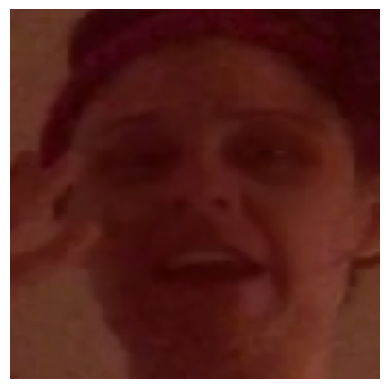

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


# 이미지 로딩 및 전처리 함수
def load_images(image_paths, target_size=(128, 128)):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0  # 정규화
        images.append(img)
    return np.array(images)

# Google Drive에서 데이터 로드 및 준비
deepfake_folder = '/content/drive/MyDrive/deepfake/'  # 실제 Deepfake 폴더 경로에 맞게 설정
image_paths = [os.path.join(deepfake_folder, f) for f in os.listdir(deepfake_folder) if f.endswith('.jpg') or f.endswith('.png')]

# 이미지 데이터 로드
x_images = load_images(image_paths)

# 라벨 생성 (FAKE: 0, REAL: 1)
y_labels = []
for img_path in image_paths:
    if 'fake' in img_path.lower():
        y_labels.append(0)  # FAKE
    else:
        y_labels.append(1)  # REAL
y_labels = np.array(y_labels)

# 데이터셋을 train, validation, test로 나누기
x_train, x_temp, y_train, y_temp = train_test_split(x_images, y_labels, test_size=0.4, random_state=42)  # 60%는 train
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)  # 20%는 validation, 20%는 test

# Encoder 모델 정의
def build_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    return Model(inputs, encoded, name="encoder")

# Decoder 모델 정의
def build_decoder(encoded_shape):
    encoded_input = tf.keras.Input(shape=encoded_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(encoded_input, decoded, name="decoder")

# Autoencoder 모델 정의
def build_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    decoder = build_decoder(encoder.output_shape[1:])
    autoencoder = Model(encoder.input, decoder(encoder.output), name="autoencoder")
    return autoencoder

# Autoencoder 모델 생성
input_shape = (128, 128, 3)  # 입력 이미지 크기
autoencoder = build_autoencoder(input_shape)

# Autoencoder 모델 컴파일
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

# Autoencoder 모델 학습
autoencoder.fit(x_train, x_train, epochs=50, batch_size=32, validation_data=(x_val, x_val))

# 분류기 모델 추가
def build_classifier(input_shape):
    encoder = build_encoder(input_shape)
    encoder_output = encoder.output
    flat = layers.Flatten()(encoder_output)
    dense = layers.Dense(64, activation='relu')(flat)
    output = layers.Dense(1, activation='sigmoid')(dense)  # 이진 분류
    classifier = Model(encoder.input, output, name="classifier")
    return classifier

# 분류기 모델 생성
classifier = build_classifier(input_shape)

# 분류 모델 컴파일
classifier.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 분류기 모델 학습
classifier.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

# Grad-CAM 계산 함수 (모델을 두 부분으로 나눠서 적용)
def get_gradcam_heatmap(model, image, class_idx):
    # 마지막 Conv2D 레이어를 찾아 부분 모델 생성
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    # 마지막 Conv2D 레이어까지의 부분 모델과, 그 이후의 분류기 부분 모델로 분리
    last_conv_layer_model = Model(inputs=model.inputs, outputs=model.get_layer(last_conv_layer_name).output)
    classifier_model = Model(inputs=model.get_layer(last_conv_layer_name).output, outputs=model.outputs)

    # 이미지를 텐서로 변환
    image = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
    with tf.GradientTape() as tape:
        # Conv 레이어 출력 및 예측값 계산
        conv_output = last_conv_layer_model(image)
        tape.watch(conv_output)
        preds = classifier_model(conv_output)
        class_output = preds[:, class_idx]  # 선택한 클래스의 예측값

    # 그라디언트 계산
    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # conv_output을 통해 heatmap 생성
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Heatmap 정규화 (np.max(heatmap) == 0 방지)
    heatmap = np.maximum(heatmap, 0)
    heatmap = np.clip(heatmap / 2, 0, 1)  # 강조 범위 축소

    return heatmap

# Grad-CAM 시각화 함수
def display_gradcam(model, image, class_idx):
    # Grad-CAM heatmap 계산
    heatmap = get_gradcam_heatmap(model, image, class_idx)

    # Heatmap을 원본 이미지 크기로 조정
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)  # heatmap의 값 0~255로 변환
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # 색상 맵 적용

    # 원본 이미지와 heatmap 합성
    superimposed_img = cv2.addWeighted(heatmap_color, 0.3, np.uint8(image * 255), 0.7, 0)  # 비율 0.3:0.7로 조정
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# 예시 호출
test_image = x_test[0]  # 첫 번째 테스트 이미지
class_idx = y_test[0]  # 해당 클래스 인덱스 (0 또는 1)

display_gradcam(classifier, test_image, class_idx)

